<div align="center">
    <H2>
        <Strong>
            Analysis on Hero Compositions in Overwatch
        </Strong>
    </H2>
    Chinhnam Nguyen, Jared Fleming, Ben Fleming
</div>

---

<div align="center">
    <H2>
        <Strong>
            Introduction
        </Strong>
    </H2>
</div>

Overwatch is a multiplayer team-based first-person shooter developed and published by Blizzard Entertainment and published in 2016. It skyrocketed in popularity quickly after release and is still going strong with at least 5 million average players each month in 2021, peaking as high as 7.3 million. Described as a "hero shooter", Overwatch assigns players into two teams of six, with each player selecting from a large roster of characters, known as "heroes", with unique abilities. Teams work to complete map-specific objectives within a limited period of time such as pushing a payload across the map or holding an area longer than the other team.

The meteoric rise in popularity also inspired both Blizzard and esports organizations to arrange their own teams and tournaments, resulting in the Overwatch League, which is produced and regulated by Blizzard themselves. Though based in the U.S., the league also features teams from Asia and Europe, resulting in 20 city-based teams, each with a max roster of 12 players. Due to its wide interchangeability between maps, gamemodes, and hero compositions (the heroes picked by each team), Overwatch is one of the most analyzed competitive games in the world. To help with this, Blizzard compiles and publicly releases the data collected throughout professional play during the year. All of the datasets can be accessed [here](https://overwatchleague.com/en-us/statslab "Overwatch League Stats Lab").

Here, we will be focusing on the data collected during the 2020 Overwatch League season, and will primarily intend to figure out the most optimal hero compositions for each map and gamemode. Heroes are meant to compliment and check each other as they are split into four classes: offense, defense, support, and tank. Obviously, we would expect a team of six attack heroes to succeed in aggressing the enemy, but would also expect them to fail miserably when defending an area. This is why finding a correct and balanced composition is integral to the game, and professional play in general.

---

<div align="center">
    <H2>
        <Strong>
            Exploring the Dataset
        </Strong>
    </H2>
</div>

We will be utilizing Python 3 and various libraries:  
[pandas](https://pandas.pydata.org/): Utilized for dataset manipulation and processing  
[numpy](https://numpy.org/): Utilized for dataset manipulation and processing  
[matplotlib](https://matplotlib.org/): Utilized for dataset manipulation and processing  
[seaborn](https://seaborn.pydata.org/): Utilized for dataset manipulation and processing  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<strong>
    Preprocessing the Dataset
</strong>

Because Blizzard released the data for 2020 in two files, one for the first half and the other for the second half, we first used Excel to combine the datasets into one. The dataset comes in the form of a CSV file.

<strong>
    Reading and Tidying the Dataset
</strong>

In [ ]:
# Read in dataset and remove uneccesary columns and stats
players1 = pd.read_csv("phs_2020/phs_2020_1.csv")
players2 = pd.read_csv("phs_2020/phs_2020_2.csv")
combine = [players1, players2]
data = pd.concat(combine).drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
data = data.reindex(columns = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount'])
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', 'Damage Blocked', 'Healing Done', 'All Damage Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)

# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']]
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0).reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned'}, inplace = True)
data.rename(columns = {'esports_match_id':'match_id'}, inplace = True)
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data.head()

Here, we can see that the finalized dataset we will be analyzing has 5 objective columns and 11 stat columns.

In [3]:
# Ignore map and average stats and prepare to plot efficiencies of each team per class
average_table = data.drop('map_name', axis=1, inplace=False)
average_table = average_table.groupby(['esports_match_id', 'team_name', 'player_name', 'hero_name']).mean().reset_index()

teams = average_table['team_name'].unique()
healers = ['Lúcio', 'Baptiste', 'Moira', 'Ana', 'Zenyatta', 'Mercy', 'Brigitte', 'Soldier: 76']
tanks = ['Reinhardt', 'Mei', 'Orisa', 'Symmetra', 'Winston', 'D.Va', 'Zarya', 'Brigitte', 'Sigma']

**Efficiencies for the players playing as healers:**

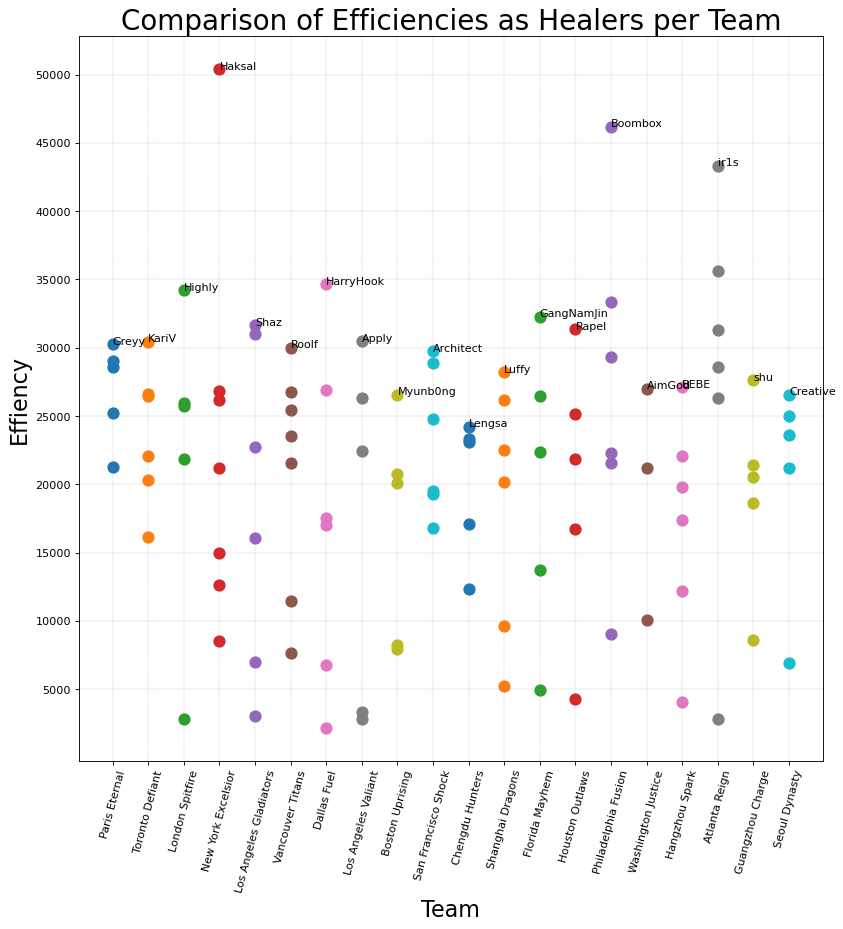

In [4]:
# Compare efficiencies of players playing as healers
tanks_table = average_table.loc[average_table['hero_name'].isin(healers)].copy()

# Define equation we will use to calculate overall efficiency and create efficiency column
def healer_efficiency(row):
    return (2*row['Assists'] + 1.5*row['Barrier Damage Done'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
            + row['Final Blows'] + 2.5*row['Healing Done'] + 1.5*row['Objective Kills'] + row['Objective Time'] + 1.5*row['Ultimates Earned'])

tanks_table['Efficiency'] = tanks_table.apply(lambda row: healer_efficiency(row), axis=1)

# Ignore rows with less than 2000 efficiency as that probably means the player only played as the healer for less than a minute
# and drop newly irrelevant columns
tanks_table = tanks_table[tanks_table.Efficiency > 2000].groupby(['team_name', 'player_name']).mean()
tanks_table = tanks_table.reset_index()
best_effiency_table = tanks_table.loc[tanks_table.groupby('team_name')['Efficiency'].idxmax()]

# Plot efficiencies of each player for each team
plot = plt.figure(figsize=(12,12), dpi=80)
plots = plot.subplots()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
for team in teams:
    plots.scatter(tanks_table.loc[tanks_table['team_name'] == team]['team_name'].tolist(), tanks_table.loc[tanks_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=100)
for index, row in best_effiency_table.iterrows():
    plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']))
plots.set_xticklabels(teams, rotation=75)
plots.set_xlabel('Team', fontsize=20)
plots.set_ylabel('Effiency', fontsize=20)
plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
plots.set_title('Comparison of Efficiencies as Healers per Team', fontsize=25)
plt.show()

**Efficiencies for the players playing as tanks:**

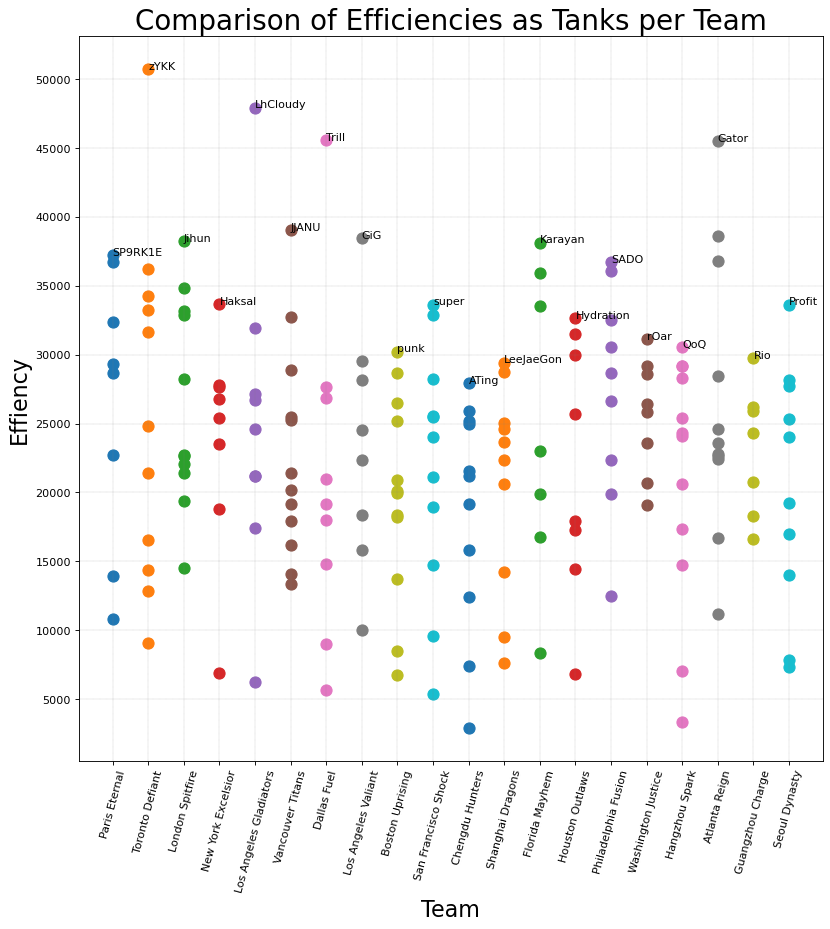

In [7]:
# Compare efficiencies of players playing as tanks
tanks_table = average_table.loc[average_table['hero_name'].isin(tanks)].copy()

# Define equation we will use to calculate overall efficiency
def tank_efficiency(row):
    return (1.5*row['Assists'] + row['Barrier Damage Done'] + 1.5*row['Damage Blocked'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
            + row['Final Blows'] + 1.5*row['Healing Done'] + 1.5*row['Objective Kills'] + 2*row['Objective Time'] + row['Ultimates Earned'])

tanks_table['Efficiency'] = tanks_table.apply(lambda row: tank_efficiency(row), axis=1)

# Ignore rows with less than 2000 efficiency as that probably means the player only played as the healer for less than a minute
# and drop newly irrelevant columns
tanks_table = tanks_table[tanks_table.Efficiency > 2000].groupby(['team_name', 'player_name']).mean()
tanks_table = tanks_table.reset_index()
best_effiency_table = tanks_table.loc[tanks_table.groupby('team_name')['Efficiency'].idxmax()]

# Plot efficiencies of each player for each team
plot = plt.figure(figsize=(12,12), dpi=80)
plots = plot.subplots()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
for team in teams:
    plots.scatter(tanks_table.loc[tanks_table['team_name'] == team]['team_name'].tolist(), tanks_table.loc[tanks_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=100)
for index, row in best_effiency_table.iterrows():
    plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']))
plots.set_xticklabels(teams, rotation=75)
plots.set_xlabel('Team', fontsize=20)
plots.set_ylabel('Effiency', fontsize=20)
plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
plots.set_title('Comparison of Efficiencies as Tanks per Team', fontsize=25)
plt.show()